### 1) внутри тенора конст, но по тенорам растёт (20% - 35%)
### 2) внутри тенора конст, но по тенорам падает (35% - 20%)
### 3) полностью разделить нампай от торча на этапе интерполяции
### 4) гамма бэквордом (2 раза бэкворд) с конст волой + вега и ро










### 1) модельно экстраполировать локал волу < 1 yr
### 2) посчитать гамму через торч для БШ

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
import py_vollib
import py_vollib.black_scholes_merton.implied_volatility
import py_vollib.black_scholes.implied_volatility
import pytz
from py_vollib.black_scholes.implied_volatility import implied_volatility
implied_volatility_vec = np.vectorize(implied_volatility)
from scipy.stats import ncx2
from scipy.stats import norm
from scipy.optimize import bisect, minimize, differential_evolution
import scipy.stats as st
from scipy import optimize
import pickle
import bisect
import sklearn
from sklearn.metrics import mean_squared_error

In [2]:
z_interval = np.arange(-4, 4, 1)
z_interval = np.append(z_interval, np.inf)
z_interval = np.insert(z_interval, 0, -np.inf)
N = z_interval.tolist().index(0)

In [33]:
spot = 1.0
T = np.array([1, 2, 3, 5])
#T = np.array([0.5, 1, 1.5])
#T = np.array([0.2, 0.4, 0.6])
#imp_vols = np.array([[0.4, 0.4, 0.4, 0.4, 0.4], [0.4, 0.4, 0.4, 0.4, 0.4], [0.4, 0.4, 0.4, 0.4, 0.4]])
#imp_vols = np.array([[0.2, 0.2, 0.2, 0.2, 0.2], [1, 1, 1, 1, 1], [0.3, 0.3, 0.3, 0.3, 0.3]])
#imp_vols = np.array([[0.43, 0.45, 0.46, 0.48], [0.51, 0.52, 0.54, 0.56], [0.57, 0.57, 0.59, 0.61], [0.68, 0.68, 0.68, 0.68]])
imp_vols = np.array([[0.3, 0.3, 0.3, 0.3], [0.35, 0.35, 0.35, 0.35], [0.4, 0.4, 0.4, 0.4], [0.45, 0.45, 0.45, 0.45]])
#imp_vols = np.array([[0.35, 0.35, 0.35, 0.35], [0.3, 0.3, 0.3, 0.3],[0.25, 0.25, 0.25, 0.25],[0.2, 0.2, 0.2, 0.2]  ])

strikes = np.array([[0.7 * spot, 0.8 * spot, 1 * spot, 1.2 * spot], [0.7 * spot, 0.8 * spot, 1 * spot, 1.2 * spot], 
    [0.7 * spot, 0.8 * spot, 1 * spot, 1.2 * spot], [0.7 * spot, 0.8 * spot,1 * spot, 1.2 * spot]])
#strikes = np.array([[1, 2], [1, 2], [1, 2]])
#strikes = np.array([[0.8 * spot,1 * spot, 1.2 * spot], [0.8 * spot, 1 * spot, 1.2 * spot], [0.8 * spot, 1 * spot, 1.2 * spot]])
r = np.array([0.05] * len(T))

## Main functions

In [34]:
def black_scholes(s, sigma, r, t, k, is_call):
    
    option_px = [np.array([]) for _ in range(len(t))]
    
    for i in range(len(t)):
        for j in range(len(k[i])):
            d_1 = (np.log(s / k[i][j]) + (r[i] + 0.5 * sigma[i][j] ** 2) * t[i]) / (sigma[i][j] * np.sqrt(t[i]))
            d_2 = d_1 - sigma[i][j] * np.sqrt(t[i])
            call_price = (s * norm.cdf(d_1) - np.exp( - r[i] * t[i]) * k[i][j] * norm.cdf(d_2))

            if is_call:
                option_px[i] = np.append(option_px[i], call_price)
            else:
                option_px[i] = np.append(option_px[i], call_price + k[i][j] * np.exp(- r[i] * t[i]) - s )
            
    #return option_px.reshape(len(tenors), len(strks[0]))
    return np.array(option_px)

In [35]:
def quadratic_root(a, b, c):
    
    D = b ** 2 - 4 * a * c
    
    if a == 0:
        return np.array([-c / b])
    
    elif D > 0:
        return np.array([(-b - np.sqrt(D)) / (2 * a), (-b + np.sqrt(D)) / (2 * a)])
    
    elif D == 0:
        return np.array([-b / (2 * a)])
    
    elif D < 0:
        return np.array([np.nan])

In [36]:
def discount_factor(r, t):
    t = np.array(t)
    r = np.array(r)
    return np.exp(-r * t)

In [37]:
def forward(S, r, t):
    t = np.array(t)
    r = np.array(r)
    return S * np.exp(r * t)

In [38]:
def beta(z, gamma, N):
    
    b = np.zeros(len(z))
    
    
    for j in range(N, len(z) - 1):
        b[j + 1] = b[j] + (z[j + 1] - z[j]) / gamma[j]
    
    for j in range(N - 1, 0, -1):
        b[j - 1] = b[j] + (z[j] - z[j + 1]) / gamma[j]
        
    return b

In [39]:
def alpha(z, gamma, N):
    
    _b = beta(z, gamma, N)
    a = np.zeros(len(z))
    
    #a[N] = a[N - 1] = 1
    
    for j in range(N, len(z) - 1):
        a[j + 1] = a[j] + _b[j] * (z[j + 1] - z[j]) + (z[j + 1] - z[j]) ** 2 / (2 * gamma[j])
    
    for j in range(N - 1, 0, -1):
        a[j - 1] = a[j] + _b[j] * (z[j] - z[j + 1]) + (z[j] - z[j + 1]) ** 2 / (2 * gamma[j])
    
    return a

In [40]:
def omega(z, gamma, N):
    
    omega = np.zeros(len(z))
    _b = beta(z, gamma, N)
    _a = alpha(z, gamma, N)
   
    for j in range(len(z) - 1):
        
        j_abs = j + 1 if j < N else j
        omega[j + 1] = omega[j] + np.sqrt(2 * np.pi * gamma[j]) * np.exp(0.5 * gamma[j] * _b[j] ** 2 - _a[j]) * \
        (st.norm.cdf((z[j + 1] - z[j_abs]) / np.sqrt(gamma[j]) + np.sqrt(gamma[j]) * _b[j]) - \
         st.norm.cdf((z[j] - z[j_abs]) / np.sqrt(gamma[j]) + np.sqrt(gamma[j]) * _b[j]))
    return omega

In [41]:
def sigma(T, sigma_imp, strikes):
    
    sigma = np.array([])
    strikes_adj = [abs(strikes[i] - spot) for i in range(len(strikes))]
    T_diff = np.diff(T)
    T_diff = np.insert(T_diff, 0, T[0])
    for i in range(len(T)):
        
        atm_index = np.argmin(strikes_adj[i])
        
        if i == 0:
            sigma = np.append(sigma, sigma_imp[i][atm_index])
            
        else:
            sigma = np.append(sigma, (T[i] * sigma_imp[i][atm_index] - np.sum(T_diff[:i] * sigma[:i])) / T_diff[i])
            
    return sigma

In [66]:
def get_lower_bound(t, T):

    idx = bisect.bisect(T, t)
    
    if idx == 0:
        return idx
    if 0 < idx <= len(T):
        return idx - 1
    else:
        raise ValueError(f"{t} is out of bounds of {T}")

In [43]:
def tau(t, T, sigma_imp, strikes, sigma0):
    arr = np.array([])
    
    T_diff = np.diff(T)
    T_diff = np.insert(T_diff, 0, T[0])
    for i in range(len(t)):
        ind = get_lower_bound(t[i], T)  
        if T[0] <= t[i] < T[1]:
            arr = np.append(arr, np.sqrt(sigma0[0] ** 2 * T[i]))

        else:
            cs = np.sum(sigma0[:ind]** 2 * T_diff[:ind])
            add = sigma0[ind] ** 2 * (t[i] - T[ind - 1])
            arr = np.append(arr, np.sqrt(cs + add))
        
    return arr

In [44]:
def z_minus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid):
    
    _b = beta(z, gamma, N)
    _a = alpha(z, gamma, N)
    _omega = omega(z, gamma, N)
    aa = np.log(_omega[-1])
    _a += aa
    z_arr = [np.array([]) for _ in range(len(t))]
    
    for i in range(len(t)):
        
        _tau = tau(t, T, sigma_imp, strikes, sigma0)[i]
        _fwd = forward(S, r, t)[i]
        
        
        for l in range(len(strikes_grid[i])):
            j_loop = True
            K = strikes_grid[i][l]
        
            for j in range(1, len(z)):
                k0 = np.argmax(z > z[j-1] + _tau)
                k1 = np.argmax(z > z[j] + _tau)
                if k1 < k0: k1 = k0
                k_loop = True
                for k in range(k0,k1+1):
                    j_abs = j if j - 1 < N else j - 1
                    k_abs = k if k - 1 < N else k - 1

                    a = 1 / (2 * gamma[k - 1]) - 1 / (2 * gamma[j - 1])
                    b = _b[k - 1] - z[k_abs] / gamma[k - 1] + _tau / gamma[k - 1] - _b[j - 1] + z[j_abs] / gamma[j - 1]
                    c = _a[k - 1] + _b[k - 1] * _tau - _b[k - 1] * z[k_abs] + (_tau - z[k_abs]) ** 2 / (2 * gamma[k - 1]) - \
                      _a[j - 1] + _b[j - 1] * z[j_abs] - z[j_abs] ** 2 / (2 * gamma[j - 1]) - np.log(_fwd / K)

                    roots = quadratic_root(a, b, c)
                    #print(roots)                              
                    for root in roots:

                        if (root >= z[j-1] and root <= z[j]) and (root + _tau >= z[k-1] and root + _tau <= z[k]):
                            
                            z_arr[i] = np.append(z_arr[i], root)
                            j_loop = False
                            k_loop = False
                            break
                    if not k_loop: break
                if not j_loop: break
    return z_arr

In [45]:
def z_pl(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid):
    
    _z_neg = z_minus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)
    zz = _z_neg.copy()
   
    for i in range(len(t)):
        _tau = tau(t, T, sigma_imp, strikes, sigma0)[i]
        #print(gamma, sigma0)
        zz[i] = np.add(zz[i], _tau)
        
    return zz

In [46]:
def delta_minus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid):
    
    omega_arr = [np.array([]) for _ in range(len(t))]
    _b = beta(z, gamma, N)
    _a = alpha(z, gamma, N)
    _omega = omega(z, gamma, N)
    om_last = _omega[-1]
    aa = np.log(om_last)
    _a += aa
   
    _omega *= np.exp(-aa)
    
    
    for i in range(len(t)):
        for l in range(len(strikes_grid[i])):
            _z = z_minus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)[i][l]
            ind = get_lower_bound(_z, z)
            j_abs = ind + 1 if ind < N else ind
            comp1 = _omega[ind]
            comp2 = np.sqrt(2 * np.pi * gamma[ind])
            comp3 = np.exp(0.5 * gamma[ind] * _b[ind] ** 2 - _a[ind])
            comp4 = st.norm.cdf((_z - z[j_abs]) / np.sqrt(gamma[ind]) + np.sqrt(gamma[ind]) * _b[ind], loc = 0, scale = 1)
            comp5 = st.norm.cdf((z[ind] - z[j_abs]) / np.sqrt(gamma[ind]) + np.sqrt(gamma[ind]) * _b[ind], loc = 0, scale = 1)

            omega_arr[i] = np.append(omega_arr[i], comp1 + comp2 * comp3 * (comp4 - comp5))
        
    return omega_arr

In [47]:
def delta_plus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid):
    
    omega_arr = [np.array([]) for _ in range(len(t))]
    _b = beta(z, gamma, N)
    _a = alpha(z, gamma, N)
    _omega = omega(z, gamma, N)
    om_last = _omega[-1]
    aa = np.log(om_last)
    _a += aa
    
    _omega *= np.exp(-aa)
    
    for i in range(len(t)):
        for l in range(len(strikes_grid[i])):
            _z = z_pl(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)[i][l]
            ind = get_lower_bound(_z, z)
            j_abs = ind + 1 if ind < N else ind
            comp1 = _omega[ind]
            comp2 = np.sqrt(2 * np.pi * gamma[ind])
            comp3 = np.exp(0.5 * gamma[ind] * _b[ind] ** 2 - _a[ind])
            comp4 = st.norm.cdf((_z - z[j_abs]) / np.sqrt(gamma[ind]) + np.sqrt(gamma[ind]) * _b[ind], loc = 0, scale = 1)
            comp5 = st.norm.cdf((z[ind] - z[j_abs]) / np.sqrt(gamma[ind]) + np.sqrt(gamma[ind]) * _b[ind], loc = 0, scale = 1)

            omega_arr[i] = np.append(omega_arr[i], comp1 + comp2 * comp3 * (comp4 - comp5))

    return omega_arr

In [48]:
def carr_pelts_call_px(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid):
    
    pxes = [np.array([]) for _ in range(len(t))]
    _fwd = forward(S, r, t)
    _df = discount_factor(r, t)
    _d_p = delta_plus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)
    _d_m = delta_minus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)
    for i in range(len(t)):
        pxes[i] = np.append(pxes[i], _df[i] * (_fwd[i] * _d_p[i] - strikes[i] * _d_m[i]))
    
    return pxes

In [49]:
def loss_px(x, t, T, S, z,  N, sigma_imp, strikes, r, strikes_grid):
    
    px = carr_pelts_call_px(t = T, T = T, S = spot, z = z_interval,
        N = N, sigma_imp = imp_vols, strikes = strikes, r = r, gamma = x[:len(z)], sigma0 = x[len(z):], strikes_grid = strikes)
    
    return np.sqrt(np.sum((px - px_bs)**2))
    #return np.sqrt(mean_squared_error(px_bs, px))

In [50]:
def cons_gamma(x, z):
    return x[:len(z)] - 0.1

In [51]:
def cons_sigma(x, z, sigma_imp):
    return x[len(z):] - np.min(sigma_imp) + 0.1

In [52]:
def calibrate_px(t, T, S, z, N, sigma_imp, strikes, r, strikes_grid):

    gamma0 = np.ones(len(z_interval))
    #gamma0 = np.linspace(0.7, 1, len(z_interval))
    sigma_init = sigma(T, sigma_imp, strikes)
    params0 = np.concatenate((gamma0, sigma_init))
    constraint_gamma = {'type': 'ineq', 'fun': cons_gamma, 'args': [z]}
    constraint_sigma = {'type': 'ineq', 'fun': cons_sigma, 'args': [z, sigma_imp]}
    res = optimize.minimize(
        fun=loss_px,
        x0=params0,
        #bounds = [[0.1, 5]] * len(z) + [[0.01, 2]] * len(T),
        constraints = [constraint_gamma, constraint_sigma],
        args=(t, T, S, z, N, sigma_imp, strikes, r, strikes_grid),
        method = 'SLSQP')

    
    return res

In [53]:
def local_vol(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid):

    loc_vol = [np.array([]) for _ in range(len(t))]
    _b = beta(z, gamma, N)
    _z_neg = z_minus(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)
    _z_pos = z_pl(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)
    
    for j in range(len(t)):
        _tau = tau(t, T, sigma_imp, strikes, sigma0)[j]
        
        for k in range(len(strikes_grid[j])):
        
            ind_pos = get_lower_bound(_z_pos[j][k], z)
            ind_neg = get_lower_bound(_z_neg[j][k], z)
            j_abs_pos = ind_pos + 1 if ind_pos < N else ind_pos
            j_abs_neg = ind_neg + 1 if ind_neg < N else ind_neg
            h_pr_plus = _b[ind_pos] + (_z_pos[j][k] - z[j_abs_pos]) / gamma[ind_pos]
            h_pr_minus = _b[ind_neg] + (_z_neg[j][k] - z[j_abs_neg]) / gamma[ind_neg]
            
            if t[j] >= T[-1]:
                sig_ind = get_lower_bound(t[j], T)
            else:
                sig_ind = get_lower_bound(t[j], T) + 1
                
            loc_vol[j] = np.append(loc_vol[j], np.sqrt(sigma0[sig_ind] ** 2 * (h_pr_plus - h_pr_minus) / _tau))
            
    return loc_vol

In [54]:
def carr_pelts_iv(t, T, S, z, N, sigma_imp, strikes, r, flag, gamma, sigma0, strikes_grid = strikes):
    
    cp_iv = [np.array([]) for _ in range(len(T))]
    _cp_px = carr_pelts_call_px(t, T, S, z, N, sigma_imp, strikes, r, gamma, sigma0, strikes_grid)
    
    for i in range(len(T)):
        cp_iv[i] = np.append(cp_iv[i], implied_volatility_vec(_cp_px[i], S, strikes[i], T[i], r[i], flag)) 
    
    return cp_iv

In [55]:
px_bs = black_scholes(s = spot, sigma = imp_vols, r = r, t = T, k = strikes, is_call = True)

In [56]:
opt_px = calibrate_px(t = T, T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r,\
                     strikes_grid = strikes)

In [57]:
lv = local_vol(t = T, T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r,
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):], strikes_grid = strikes)

In [58]:
cp = carr_pelts_call_px(t = T, T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r,
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):], strikes_grid = strikes)

In [59]:
cp_iv = carr_pelts_iv(t = T, T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r, flag = 'c',
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):], strikes_grid = strikes)

In [60]:
lv

[array([0.39358662, 0.39370437, 0.39373519, 0.39360231]),
 array([0.48473743, 0.48480094, 0.48478591, 0.48466414]),
 array([0.51601451, 0.51603685, 0.5160042 , 0.51593805]),
 array([0.51601599, 0.51603115, 0.51599278, 0.51596142])]

### Carr Pelts IV

In [50]:
def carr_pelts_iv(T, S, z, N, sigma_imp, strikes, r, flag, gamma, sigma0):
    
    cp_iv = [np.array([]) for _ in range(len(T))]
    _cp_px = carr_pelts_call_px(T, S, z, N, sigma_imp, strikes, r, gamma, sigma0)
    
    for i in range(len(T)):
        cp_iv[i] = np.append(cp_iv[i], implied_volatility_vec(_cp_px[i], S, strikes[i], T[i], r[i], flag)) 
    
    return cp_iv

In [144]:
cp_iv = carr_pelts_iv(T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r, flag = 'c',
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):])

In [60]:
imp_vols - cp_iv

array([[ 0.02502406,  0.01729425, -0.00479998, -0.01906041,  0.00111897,
         0.00138951, -0.0017172 , -0.0095212 , -0.00235815,  0.01779734],
       [ 0.05344435, -0.02214201, -0.03058803, -0.08495054,  0.02937967,
         0.02956841,  0.03288969, -0.02274109, -0.00255963,  0.01125144],
       [ 0.05839541,  0.02323801,  0.01772628,  0.01184054,  0.01162622,
         0.00593569, -0.01147334, -0.01705123,  0.0120386 , -0.05905   ],
       [-0.10999783, -0.06582208,  0.04661722, -0.04471608,  0.02412301,
         0.02094246,  0.01779512,  0.00734684,  0.006103  ,  0.00075042],
       [ 0.03942806, -0.13664565,  0.00920422,  0.06118781, -0.06761217,
        -0.06581151, -0.01904642,  0.0220791 ,  0.03905241,  0.03021309],
       [ 0.09355607, -0.22175287,  0.04997764,  0.00795757,  0.0029578 ,
         0.02317968,  0.01722044, -0.03958408,  0.00745327, -0.00760577]])

## Calibration to IV

In [26]:
def loss(x, T, S, z,  N, sigma_imp, strikes, r, flag):
    
    iv = carr_pelts_iv(T = TT, S = spot, z = z_interval, N = N, sigma_imp = ww, 
    strikes = strk, r = r, flag = 'c', gamma = x[:len(z)], sigma0 = x[len(z):])
    
    return np.sqrt(np.sum((np.asarray(iv) - np.asarray(ww))**2))

In [69]:
def calibrate(T, S, z, N, sigma_imp, strikes, r, flag):

    gamma0 = np.ones(len(z_interval)) * 1
    #gamma0 = np.linspace(0.7, 1, len(z_interval))
    sigma_init = sigma(T, sigma_imp, strikes)
    params0 = np.concatenate((gamma0, sigma_init))
    constraint_gamma = {'type': 'ineq', 'fun': cons_gamma, 'args': [z]}
    constraint_sigma = {'type': 'ineq', 'fun': cons_sigma, 'args': [z]}
    res = optimize.minimize(
        fun=loss,
        x0=params0,
        #bounds = [[0.1, 5]] * len(z) + [[0.01, 2]] * len(T),
        constraints = [constraint_gamma, constraint_sigma],
        args=(T, S, z, N, sigma_imp, strikes, r,flag),
        method = 'SLSQP')

    
    return res

In [70]:
opt = calibrate(T = T, S = spot, z = z_interval, N = N, sigma_imp = w, strikes = strikes, r = r, flag = 'c')

In [71]:
carr_pelts_iv(T = T, S = spot, z = z_interval, N = N, sigma_imp = w, strikes = strikes, r = r, flag = 'c',
                  gamma = opt.x[:len(z_interval)], sigma0 = opt.x[len(z_interval):])

[array([0.83151337, 0.844454  , 0.86166282]),
 array([0.48165584, 0.48842315, 0.49502975]),
 array([0.37204986, 0.37914101, 0.38363565])]

# MC

In [61]:
import torch

In [32]:
def locvol_interp(T, strikes, lv, time, price):
    #T = torch.from_numpy(T)
    cs = [np.array([]) for _ in range(len(T))]
    xs = np.linspace(np.min(strikes), np.max(strikes), 100)
    #xs = torch.linspace(torch.min(torch.from_numpy(strikes)), torch.max(torch.from_numpy(strikes)), 100)
    #print(xs)
    for i in range(len(T)):
    
        cs[i] = np.append(cs[i], CubicSpline(strikes[i], lv[i], bc_type = 'natural', extrapolate = True)(xs))
    #print(cs)
    return RectBivariateSpline(T, xs, cs)(time, price, grid = False)
    #return torch.from_numpy(RectBivariateSpline(T, xs, cs)(time, price, grid = False))#, \
#RectBivariateSpline(T, xs, cs).get_coeffs()

## interpolated lv

In [47]:
tt = np.array([1, 1.5, 2, 2.5, 2.75, 3, 3.5, 4, 4.5, 5])
pp = np.array([np.arange(0.7, 1.25, 0.05)] * len(tt))
#pp = np.array([np.linspace(0.7, 1.2, len(tt))] * len(tt))
r = np.array([0.05] * len(tt))

In [48]:
import timeit
from datetime import datetime
now1 = datetime.now()
start = timeit.timeit()
lv_spline = [np.array([]) for _ in range(len(tt))]

for i in range(len(tt)):
    lv_spline[i] = np.append(lv_spline[i], locvol_interp(T, strikes, lv, tt[i], pp[0]))
    
end = timeit.timeit() 
now2 = datetime.now()
print(end - start)
print(now2 - now1)

-0.00030839999089948833
0:00:00.047283


In [49]:
start1 = timeit.timeit()
now3 = datetime.now()
lv_model = local_vol(t = tt, T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r,
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):], strikes_grid = pp)

end1 = timeit.timeit() 
now4 = datetime.now()
print(end1 - start1)
print(now4 - now3)

-0.0001401000190526247
0:00:00.092546


### decreasing term structure

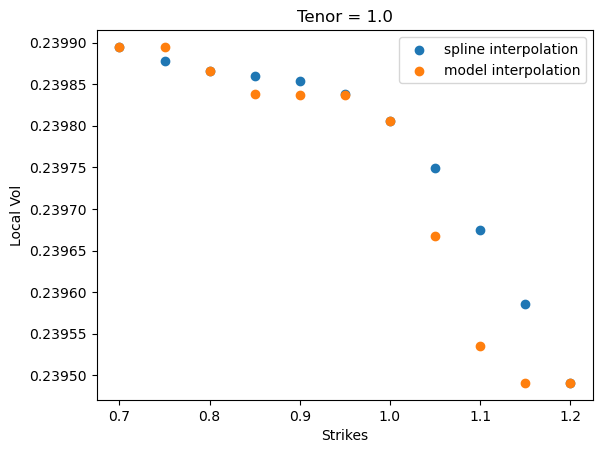

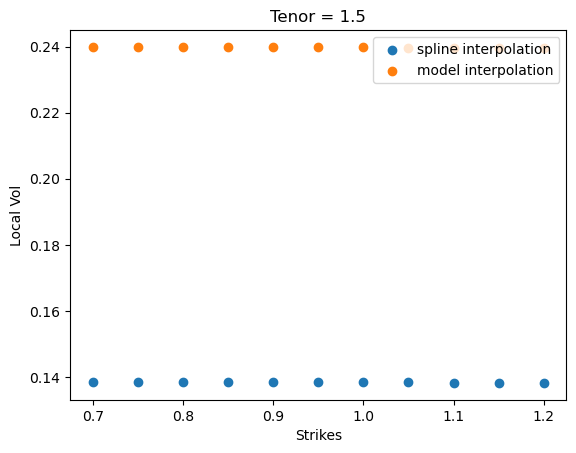

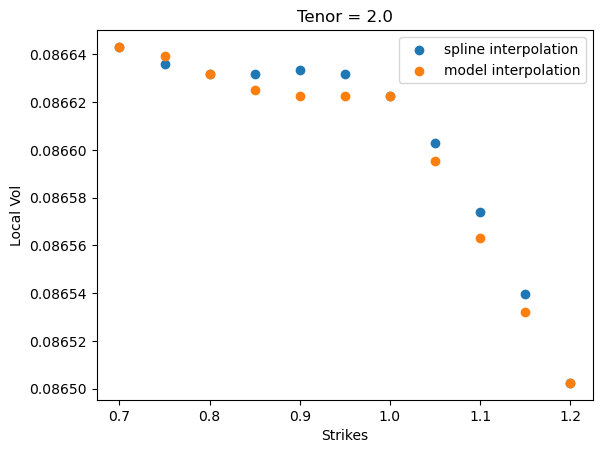

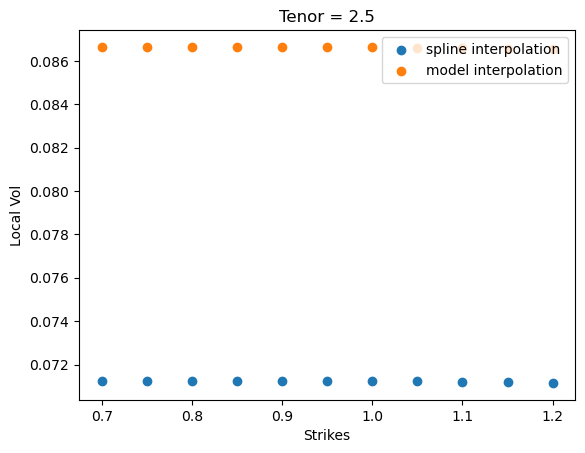

In [50]:
for i in range(len(lv)):
    plt.figure()
    plt.scatter(pp[i], lv_spline[i], label = 'spline interpolation')
    plt.scatter(pp[i], lv_model[i], label = 'model interpolation')
    
    plt.title(f'Tenor = {tt[i].round(3)}')
    
    plt.xlabel("Strikes")
    plt.ylabel("Local Vol")
    plt.legend(loc="upper right")
    plt.show()

### increasing term structure

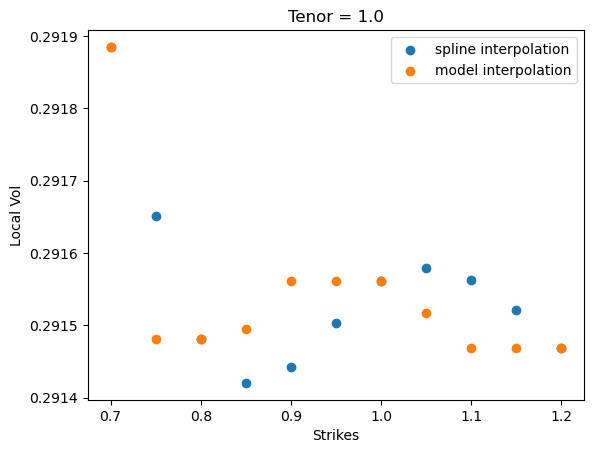

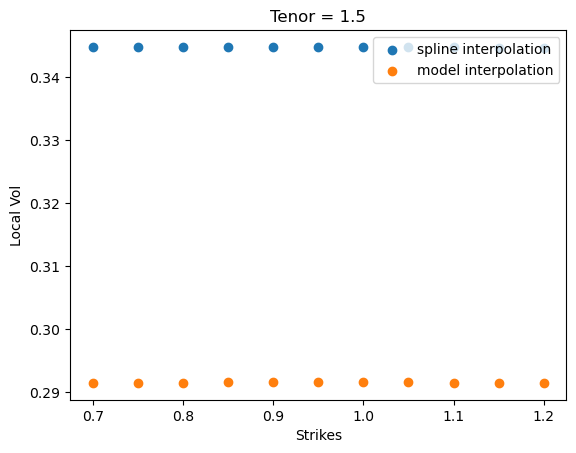

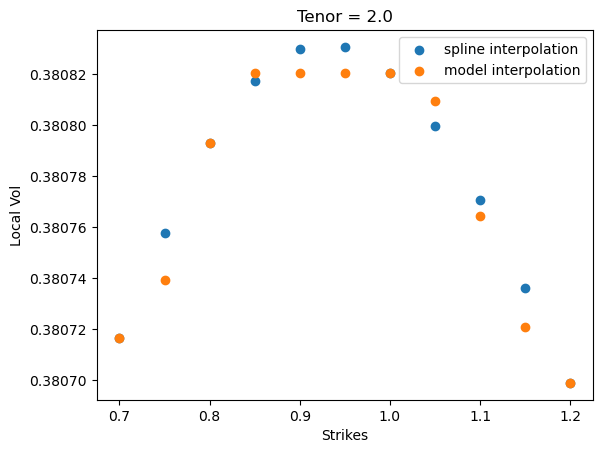

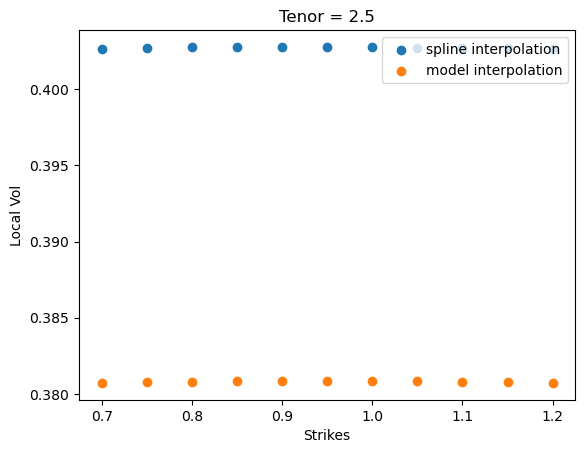

In [37]:
for i in range(len(lv)):
    plt.figure()
    plt.scatter(pp[i], lv_spline[i], label = 'spline interpolation')
    plt.scatter(pp[i], lv_model[i], label = 'model interpolation')
    
    plt.title(f'Tenor = {tt[i].round(3)}')
    
    plt.xlabel("Strikes")
    plt.ylabel("Local Vol")
    plt.legend(loc="upper right")
    plt.show()

## Sobol

In [72]:
def qmc(N_times, m):
    
    #N_times = 12 * expiration
    soboleng = torch.quasirandom.SobolEngine(dimension = N_times, scramble = True)
    return norm.ppf(soboleng.draw_base2(m))

In [57]:
def locvol_interp(T, strikes, lv, time, price):
    
    cs = [np.array([]) for _ in range(len(T))]
    xs = np.linspace(np.min(strikes), np.max(strikes), 100)
    
    for i in range(len(T)):
        
        cs[i] = np.append(cs[i], CubicSpline(strikes[i], lv[i], bc_type = 'natural', extrapolate = True)(xs))

    res = RectBivariateSpline(T, xs, cs)(time, price, grid = False)

    return res

In [58]:
locvol_interp(T, strikes, lv, 2.5, 1.5)

array(0.07115296)

### Const Local Volatility

In [80]:
def Generate_paths(N_times, spot, m, r, expiration):
    
    Z = qmc(N_times, m)
    px = torch.zeros((2 ** m, N_times + 1))
    px[:, 0] = spot
    t = torch.zeros([N_times + 1])
    expiration = torch.tensor(expiration)
    r = torch.tensor(r)
    dt = torch.tensor(expiration / N_times)
    
    for i in range(N_times):
        #_t = np.array([t[i]])
        _px = np.array([np.array(px[: , i])])
              #  _t = torch.Tensor.numpy(t[i])
       # _px = torch.Tensor.numpy(px[:, i])
        
        if t[i] < T[0]:
            
            lv = local_vol(t = np.array([T[0]]), T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r,
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):], strikes_grid = _px)
            _lv = torch.tensor(lv)
        
            px[: , i+1] = px[: , i] * (1 + r * dt + _lv * torch.sqrt(dt) * Z[:,i])   
            t[i + 1] = t[i] + dt
            
        else:
            
            lv = local_vol(t = np.array([t[i]]), T = T, S = spot, z = z_interval, N = N, sigma_imp = imp_vols, strikes = strikes, r = r,
                  gamma = opt_px.x[:len(z_interval)], sigma0 = opt_px.x[len(z_interval):], strikes_grid = _px)
            _lv = torch.tensor(lv)
        
            px[: , i+1] = px[: , i] * (1 + r * dt + _lv * torch.sqrt(dt) * Z[:,i])   
            t[i + 1] = t[i] + dt
        
    paths = {"Time" : t, "Price": px}
    price_last = px[:, -1]
    
    return price_last

In [81]:
Generate_paths(N_times = 12, spot=1, m=5, r=0.05, expiration=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(expiration / N_times)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\torch\csrc\utils\tensor_new.cpp:204.)
  _lv = torch.tensor(lv)


tensor([1.0713, 1.0064, 0.2197, 3.0140, 0.8849, 1.2372, 0.4592, 0.4655, 0.4777,
        1.9918, 0.5584, 1.8113, 0.4100, 0.7641, 0.9043, 3.0574, 2.6069, 0.5945,
        0.2668, 2.2335, 0.3446, 2.3968, 1.4340, 0.2166, 0.5519, 1.2834, 1.5063,
        0.4154, 0.6266, 0.9694, 0.8506, 1.3586])

In [88]:
def calc_option_px(N_times, K, spot, m, r, expiration):
    
    res = Generate_paths(N_times, spot, m, r, expiration)
    
    return torch.exp(torch.tensor(-r * expiration)) * torch.sum(res[res - K > 0] - K) / res.size(dim = 0)

In [89]:
def delta_calc(N_times, K, spot1, spot2, m, r, expiration):
    
    option_price1 = calc_option_px(N_times, K, spot1, m, r, expiration)
    option_price2 = calc_option_px(N_times, K, spot2, m, r, expiration)
    
    #print(option_price1)
    #print(option_price2)
    
    return (option_price2 - option_price1) / (spot2 - spot1)

In [91]:
delta_calc(N_times = 36, K = 1, spot1=1, spot2=1.01, m=10, r=0.05, expiration=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(expiration / N_times)


tensor(0.3292)

In [92]:
def gamma_calc(N_times, K, spot, h, m, r, expiration):
    
    option_price = calc_option_px(N_times, K, spot, m, r, expiration)
    option_price1 = calc_option_px(N_times, K, spot + h, m, r, expiration)
    option_price2 = calc_option_px(N_times, K, spot - h, m, r, expiration)
    
    #print(option_price1)
    #print(option_price2)
    
    return (option_price2 - 2 * option_price + option_price1) / (h ** 2)

In [93]:
gamma_calc(N_times = 36, K = 1, spot = spot, h = 0.01, m=10, r=0.05, expiration=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(expiration / N_times)


tensor(278.8481)

In [95]:
def Greeks(N_times, K, spot, m, r, expiration):
    # setup gradient functions to evaluate with AAD
    spot = torch.tensor(spot, requires_grad=True)
    #print(spot)
    #lv = torch.tensor(lv, requires_grad=True)
    #strikes = torch.tensor(strikes, requires_grad=False)
    expiration = torch.tensor(expiration, requires_grad=True)
    r = torch.tensor(r, requires_grad=True)
    
    NPV = calc_option_px(N_times, K, spot, m, r, expiration)
    NPV.backward()
    
    theta = expiration.grad
    delta = spot.grad
    #vega = lv.grad
    rho = r.grad
    return NPV, delta, rho, theta

In [96]:
Greeks(N_times = 24, K = 1.0, spot=1.0, m=8, r=0.05, expiration=3.)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expiration = torch.tensor(expiration)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24928\3735857551.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(expiration / N_times)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.